# How to use SAM model 

https://blog.roboflow.com/how-to-use-segment-anything-model-sam/

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [4]:
import os
import argparse
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import supervision as sp
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
img_path = os.path.join(os.getcwd(), 'testimgs', 'image_0001.jpg')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

MODEL_TYPE = 'vit_h'
SAM_CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints', 'sam_vit_h_4b8939.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH).to(device=device)
sam.to(device=device)

masks_generator = SamAutomaticMaskGenerator(sam)

masks = masks_generator.generate(img)

In [ ]:
# NOT WORKING

mask_annotator = sp.MaskAnnotator()

detections = sp.Detections.from_sam(masks)

annotated_img = mask_annotator.annotate(img, detections)

In [7]:
print(len(masks))
print(type(masks))

print(img.shape)
print(164*398)

46
<class 'list'>
(164, 398, 3)
65272


In [ ]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

seg_masks = []


for idx, i in enumerate(masks):
    print(idx, i)
    seg_mask = i['segmentation']
    seg_mask = np.array(seg_mask * 255).astype('uint8')
    seg_mask = cv2.cvtColor(seg_mask, cv2.COLOR_GRAY2BGR)
    seg_masks.append(seg_mask)

    box = i['bbox']
    x0, y0, w, h = box
    crop = img[y0:y0+h, x0:x0+w]
    # cv2.imwrite(f'crop_{idx}.jpg', crop)


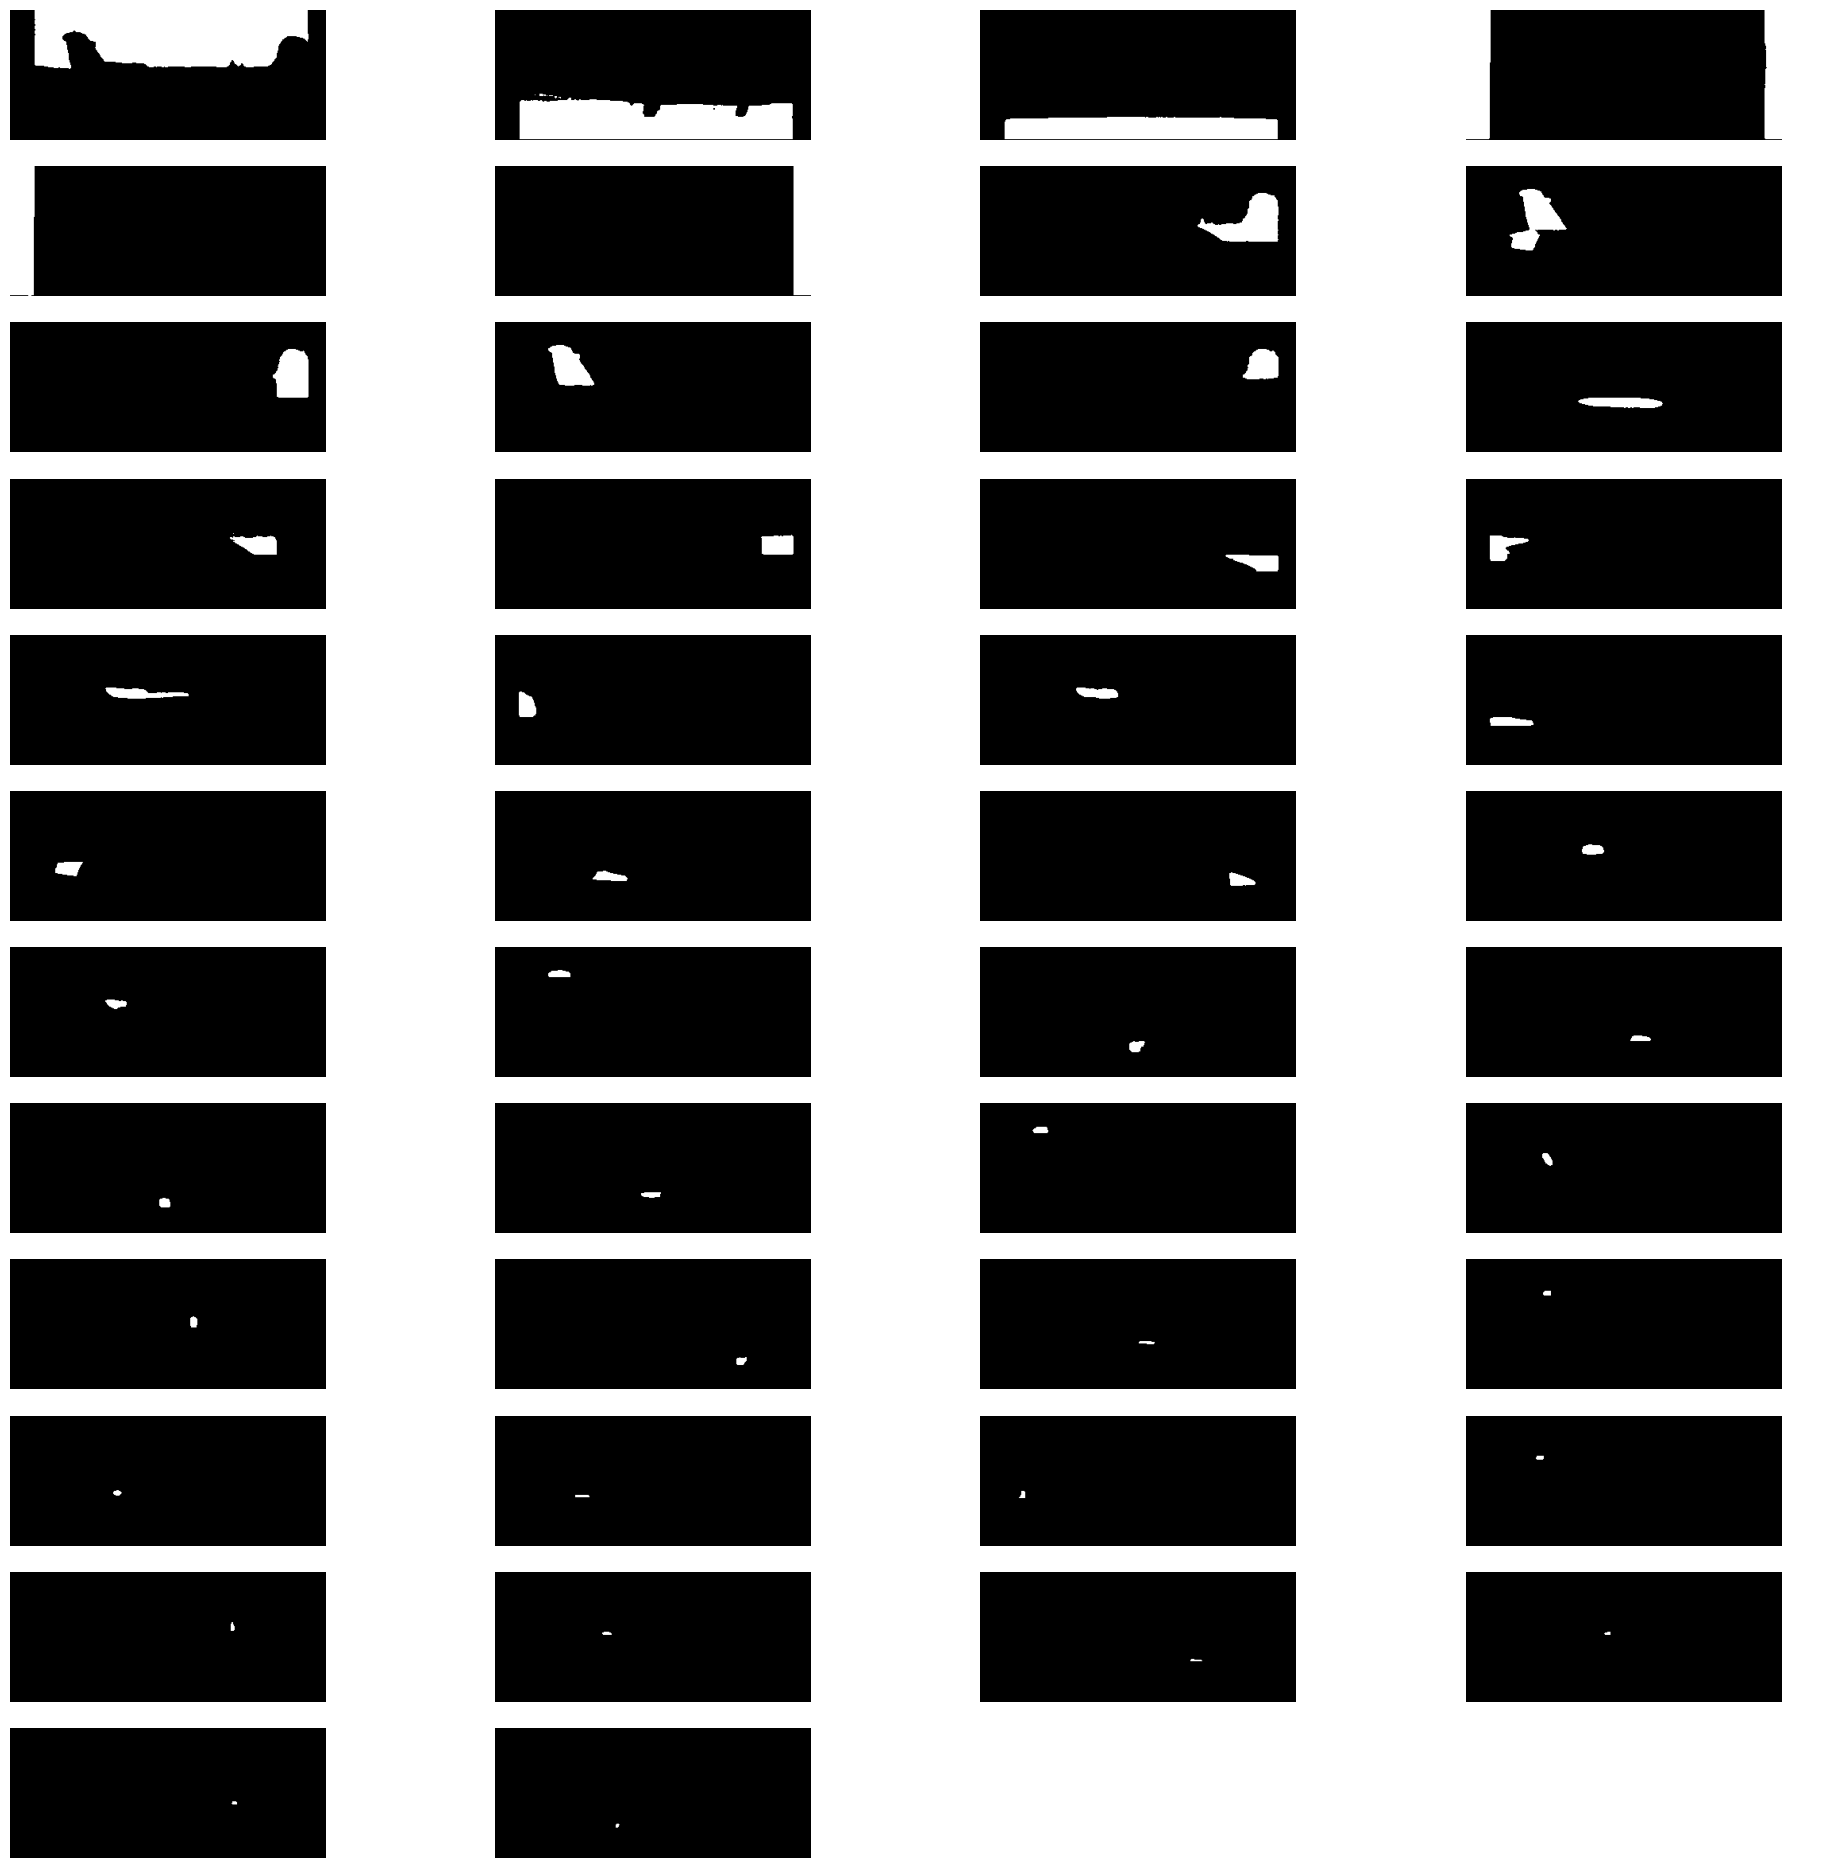

In [9]:
sp.plot_images_grid(
    images=seg_masks,
    grid_size=(12, 4),
    size=(24, 24)
)

In [10]:
def show_all_masks(masks):
    sorted_masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones(
        (
            sorted_masks[0]["segmentation"].shape[0],
            sorted_masks[0]["segmentation"].shape[1],
            4,
        )
    )
    img[:, :, 3] = 0
    for mask in sorted_masks:
        m = mask["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


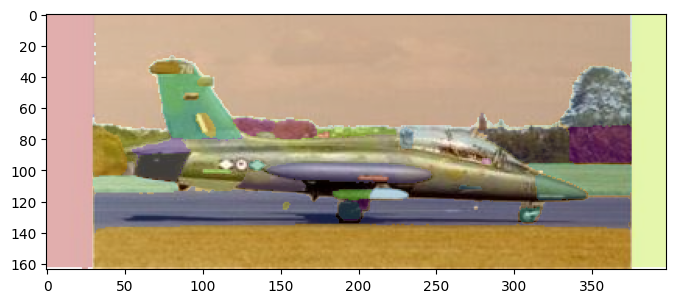

In [11]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
show_all_masks(masks)

### Improving image search

Rather than passing entire input image into db, we can use GroundingDINO to do zero-shot object detection and extract those objects as query?

In [ ]:
!mkdir -p weights
!cd weights

!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [1]:
import os
import supervision as sv
import torch
import numpy as np
import cv2

In [69]:
!git clone git@github.com:IDEA-Research/GroundingDINO.git

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
# %cd GroundingDINO
# !pip install -e .
%cd ../

/home/chee/workprojects/TORCH_TUTS_2023/IMAGE_SEARCH/CustomImageSearcher


In [2]:
HOME = os.getcwd()
print(HOME)
CONFIG = os.path.join(HOME, 'GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py')
print(os.path.exists(CONFIG))

/home/chee/workprojects/TORCH_TUTS_2023/IMAGE_SEARCH/CustomImageSearcher
True


In [3]:
WEIGHTS_NAME = 'groundingdino_swint_ogc.pth'

WEIGHTS_PATH = os.path.join(HOME, 'weights', WEIGHTS_NAME)

print(os.path.exists(WEIGHTS_PATH))

True


In [4]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

In [80]:
IMAGE_NAME = 'image_0002.jpg'
IMAGE_PATH = os.path.join(HOME, 'testimgs', IMAGE_NAME)

TEXT_PROMPT = 'cats'
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

In [81]:
model = load_model(CONFIG, WEIGHTS_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

print(f'BOXES PREDICTION: {boxes}, LOGITS: {logits}, PHARASES: {phrases}')

final text_encoder_type: bert-base-uncased
BOXES PREDICTION: tensor([[0.4771, 0.4500, 0.9508, 0.6156]]), LOGITS: tensor([0.4672]), PHARASES: ['cats']


In [82]:
annotated_frame = annotate(
    image_source=image_source,
    boxes=boxes,
    logits=logits,
    phrases=phrases
)

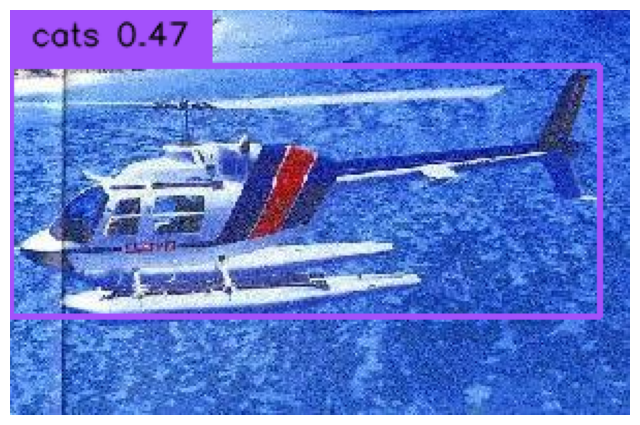

In [83]:
%matplotlib inline

sv.plot_image(annotated_frame, (8, 8))

In [56]:
def get_max_object(img, boxes):
    if len(boxes) == 0:
        return img

    max_area = 0
    for box in boxes:
        x1, y1, x2, y2 = box
        area = (x2-x1)*(y2-y1)
        if area > max_area:
            max_area = area
            max_img = img[y1:y2,x1:x2,:]

    return max_img

In [ ]:
h, w, _ = image_source.shape

# Convert floating point box coords to actual image coords
coords_boxes = []

for idx, b in enumerate(boxes):
    box = b * torch.Tensor([w, h, w, h])
    box[:2] -= box[2:] / 2
    box[2:] += box[:2]
    x0, y0, x1, y1 = box.int().tolist()
    input_box = np.array([x0,y0,x1,y1])

    print(input_box)
    coords_boxes.append(input_box)

print(coords_boxes)
res = get_max_object(image_source, coords_boxes)
print(type(res))
print(res.shape)
cv2.imwrite(f'query_final.jpg', cv2.cvtColor(res, cv2.COLOR_BGR2RGB))


    # res = get_max_object(image_source, [input_box])
    # print(type(res))
    # print(res.shape)
    
    # cv2.imwrite(f'query_{idx}.jpg', cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [84]:
# Don't use get_max_object as it can return a larger image with background which can skew search
# Get box coords of logits with highest values

h, w, _ = image_source.shape

# print(logits)
# print(type(logits))
max_logit = torch.argmax(logits)
print(max_logit)

max_box = boxes[max_logit]
print(max_box)

box = max_box * torch.Tensor([w, h, w, h])
box[:2] -= box[2:] / 2
box[2:] += box[:2]
x0, y0, x1, y1 = box.int().tolist()
input_box = np.array([x0,y0,x1,y1])
print(input_box)

res = image_source[y0:y1,x0:x1,:]

print(type(res))
print(res.shape)
cv2.imwrite(f'query_final.jpg', cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

tensor(0)
tensor([0.4771, 0.4500, 0.9508, 0.6156])
[  0  27 285 148]
<class 'numpy.ndarray'>
(121, 285, 3)


True